In [ ]:
!nvidia-smi

Wed May 11 05:24:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import modules

In [ ]:
import torch

import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import CIFAR100
from torch.cuda import is_available
from torchvision import transforms
from datetime import datetime

%matplotlib inline

In [ ]:
device='cuda' if is_available() else 'cpu'
device

'cuda'

# Download dataset and calculate means and stds

In [ ]:
all_data=CIFAR100(root='.',train=True,transform=transforms.ToTensor(),download=True)

meanRGB=[np.mean(x.numpy(),axis=(1,2)) for x,_ in all_data]
stdRGB=[np.std(x.numpy(),axis=(1,2)) for x,_ in all_data]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print('Mean:',meanR, meanG, meanB)
print('Std:',stdR, stdG, stdB)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./cifar-100-python.tar.gz to .
Mean: 0.50707513 0.48654887 0.44091785
Std: 0.20079845 0.19834627 0.20219834


# Implement CustomSubset

To use different augmentations to train subset and validation subset.

In [ ]:
class CustomSubset(Dataset):
    def __init__(self,Subset,transform=None):
        super(CustomSubset,self).__init__()
        self.Subset=Subset
        self.indices=Subset.indices
        self.transform=transform

    def __len__(self):
        return len(self.Subset)

    def __getitem__(self,idx):
        img,label=self.Subset[idx]
        if self.transform is not None:
            img=self.transform(img)
        return img,label

In [ ]:
transform={
    'train':transforms.Compose([
                                transforms.RandomCrop((32, 32), padding=4),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),
                                transforms.Normalize([meanR,meanG,meanB],[stdR,stdG,stdB])
            ]),
    'test':transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize([meanR,meanG,meanB],[stdR,stdG,stdB])
            ])
}

train_ratio=0.8
train_data_len=int(len(all_data)*0.8)
valid_data_len=len(all_data)-train_data_len

train_data,valid_data=random_split(all_data,[train_data_len,valid_data_len])

all_data.transform=None
train_data=CustomSubset(train_data,transform['train'])
valid_data=CustomSubset(valid_data,transform['test'])
test_data=CIFAR100(root='.',train=False,transform=transform['test'],download=True)

Files already downloaded and verified


# Define blocks

In [ ]:
class BottleNeck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(BottleNeck, self).__init__()
        inner_channels = 4 * growth_rate
        self.bottle_neck = nn.Sequential(nn.BatchNorm2d(in_channels),
                                         nn.ReLU(inplace=True),
                                         nn.Conv2d(in_channels, inner_channels, kernel_size=1, bias=False),
                                         nn.BatchNorm2d(inner_channels),
                                         nn.ReLU(inplace=True),
                                         nn.Conv2d(inner_channels, growth_rate, kernel_size=3, padding=1, bias=False))
            
    def forward(self, x):
        return torch.cat([x, self.bottle_neck(x)], dim=1)

class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Transition, self).__init__()
        self.down_sample = nn.Sequential(nn.BatchNorm2d(in_channels),
                                         nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                                         nn.AvgPool2d(kernel_size=2, stride=2))
        
    def forward(self, x):
        return self.down_sample(x)

# Define DenseNet121

In [ ]:
class DenseNet121(nn.Module):
    def __init__(self, num_blocks=[6, 12, 24, 16], num_classes=100, growth_rate=32, reduction=0.5):
        super(DenseNet121, self).__init__()
        self.growth_rate = growth_rate

        inner_channels = 2 * growth_rate
        
        self.conv1 = nn.Conv2d(3, inner_channels, kernel_size=3, padding=1, bias=False)

        self.features = nn.Sequential()

        for idx in range(len(num_blocks)):
            dense_layers = []
            for j in range(num_blocks[idx]):
                dense_layers.append(BottleNeck(inner_channels, self.growth_rate))
                inner_channels += self.growth_rate
            self.features.add_module(f'dense_block_layer_{idx}', nn.Sequential(*dense_layers))
            if idx != (len(num_blocks) - 1):
                out_channels = int(reduction * inner_channels)
                self.features.add_module(f'transition_layer_{idx}', Transition(inner_channels, out_channels))
                inner_channels = out_channels

        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('relu', nn.ReLU(inplace=True))
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(inner_channels, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.linear(x)
        return x
        

# Prepare training step

In [ ]:
batch_size = 128

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
model = DenseNet121(num_classes=100)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)

model = model.to(device)
criterion = criterion.to(device)

# Train and validation

In [ ]:
def train(model, criterion, optimizer, train_loader, valid_loader, num_epochs=10, print_every=1, early_stop=None, model_path='densenet121.pth'):
    train_logs = {'Loss':[], 'Accuracy':[]}
    valid_logs = {'Loss':[], 'Accuracy':[]}
    try:
        patience = 0
        best_acc = -np.inf
        start_time = datetime.now()
        for epoch in range(num_epochs):
            train_loss = 0
            valid_loss = 0
            train_acc = 0
            valid_acc = 0
            # training step
            model.train()
            for data, target in train_loader:
                optimizer.zero_grad()
                data, target = data.to(device), target.to(device)
                pred = model(data)
                loss = criterion(pred,target)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * data.size(0)
                train_acc += torch.sum(pred.argmax(1) == target).item()
            train_loss /= len(train_data)
            train_acc /= len(train_data)
            train_logs['Loss'].append(train_loss)
            train_logs['Accuracy'].append(train_acc)
            if (epoch + 1) % print_every == 0:
                print('Training   Epoch {} - Loss : {:.8f} Accuracy : {:.4f}% Time elapsed: {}'.format(epoch, train_loss, train_acc * 100, datetime.now() - start_time))
            # validation step
            with torch.no_grad():
                model.eval()
                for data, target in valid_loader:
                    data, target = data.to(device), target.to(device)
                    pred = model(data)
                    loss = criterion(pred,target)
                    valid_loss += loss.item() * data.size(0)
                    valid_acc += torch.sum(pred.argmax(1) == target).item()
                valid_loss /= len(valid_data)
                valid_acc /= len(valid_data)
                valid_logs['Loss'].append(valid_loss)
                valid_logs['Accuracy'].append(valid_acc)
                if (epoch+1) % print_every == 0:
                    print('Validation Epoch {} - Loss : {:.8f} Accuracy : {:.4f}% Time elapsed: {}'.format(epoch, valid_loss, valid_acc * 100, datetime.now() - start_time))
                if valid_acc > best_acc:
                    best_acc = valid_acc
                    torch.save(model.state_dict(), model_path)
                    if early_stop is not None:
                        patience = 0
                elif early_stop is not None:
                    patience += 1
                    if patience >= early_stop:
                        print('Training finished by early stopping')
                        return train_logs, valid_logs
        return train_logs, valid_logs
    except KeyboardInterrupt:
        return train_logs, valid_logs

In [ ]:
train_logs, valid_logs = train(model=model,
                               criterion=criterion,
                               optimizer=optimizer,
                               train_loader=train_loader,
                               valid_loader=valid_loader,
                               num_epochs=50,
                               print_every=1,
                               early_stop=None,
                               model_path='densenet121.pth')

Training   Epoch 0 - Loss : 4.16967633 Accuracy : 6.0800% Time elapsed: 0:01:49.299993
Validation Epoch 0 - Loss : 11.28758694 Accuracy : 1.7200% Time elapsed: 0:01:58.392492
Training   Epoch 1 - Loss : 3.75929782 Accuracy : 11.3825% Time elapsed: 0:03:47.500052
Validation Epoch 1 - Loss : 3.87460337 Accuracy : 10.5900% Time elapsed: 0:03:56.560028
Training   Epoch 2 - Loss : 3.58359371 Accuracy : 14.4300% Time elapsed: 0:05:45.606955
Validation Epoch 2 - Loss : 3.69462843 Accuracy : 13.4200% Time elapsed: 0:05:54.638145
Training   Epoch 3 - Loss : 3.47948880 Accuracy : 16.6825% Time elapsed: 0:07:43.793777
Validation Epoch 3 - Loss : 3.57701419 Accuracy : 15.8600% Time elapsed: 0:07:52.855109
Training   Epoch 4 - Loss : 3.39812981 Accuracy : 17.8600% Time elapsed: 0:09:41.867607
Validation Epoch 4 - Loss : 4.44294021 Accuracy : 13.5200% Time elapsed: 0:09:50.907305
Training   Epoch 5 - Loss : 3.32397045 Accuracy : 19.5075% Time elapsed: 0:11:39.863152
Validation Epoch 5 - Loss : 3.321

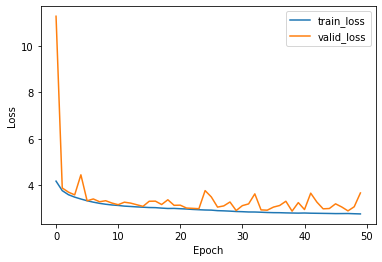

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot([i for i in range(len(train_logs['Loss']))], train_logs['Loss'], label='train_loss')
plt.plot([i for i in range(len(valid_logs['Loss']))], valid_logs['Loss'], label='valid_loss')
plt.legend()
plt.show()

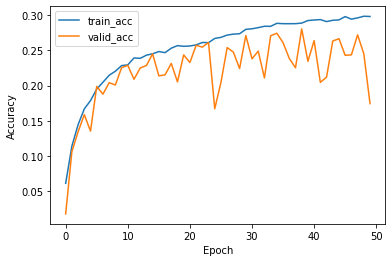

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot([i for i in range(len(train_logs['Accuracy']))], train_logs['Accuracy'], label='train_acc')
plt.plot([i for i in range(len(valid_logs['Accuracy']))], valid_logs['Accuracy'], label='valid_acc')
plt.legend()
plt.show()

# Test

In [ ]:
model.load_state_dict(torch.load('densenet121.pth'))
model = model.to(device)

In [ ]:
def test(model,criterion,test_loader):
    test_loss = 0
    test_acc = 0
    result_table = pd.DataFrame(columns=['Prediction', 'Target'])
    with torch.no_grad():
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device) ,target.to(device)
            pred = model(data)
            loss = criterion(pred, target)
            test_loss += loss.item() * data.size(0)
            test_acc += torch.sum(pred.argmax(1) == target).item()
            for p, t in zip(pred.argmax(1), target):
                result_table = result_table.append({'Prediction':p.item(), 'Target':t.item()}, ignore_index=True)
        test_loss /= len(test_data)
        test_acc /= len(test_data)
    return test_loss, test_acc, result_table

In [ ]:
test_loss, test_acc, result_table = test(model=model,
                                         criterion=criterion,
                                         test_loader=test_loader)

In [ ]:
print('Test Loss : {:.8f} Test Accuracy : {:.4f}%'.format(test_loss, test_acc * 100))

Test Loss : 2.84657677 Test Accuracy : 28.2900%


In [ ]:
result_table

,Prediction,Target
0,49,49
1,63,33
2,89,72
3,58,51
4,71,71
...,...,...
9995,92,83
9996,74,14
9997,33,51
9998,42,42
